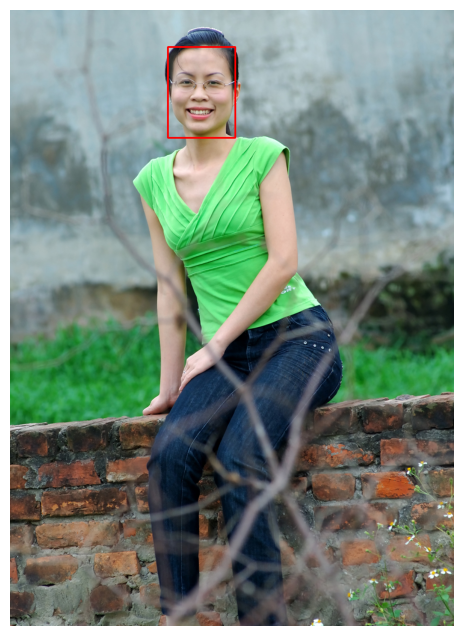

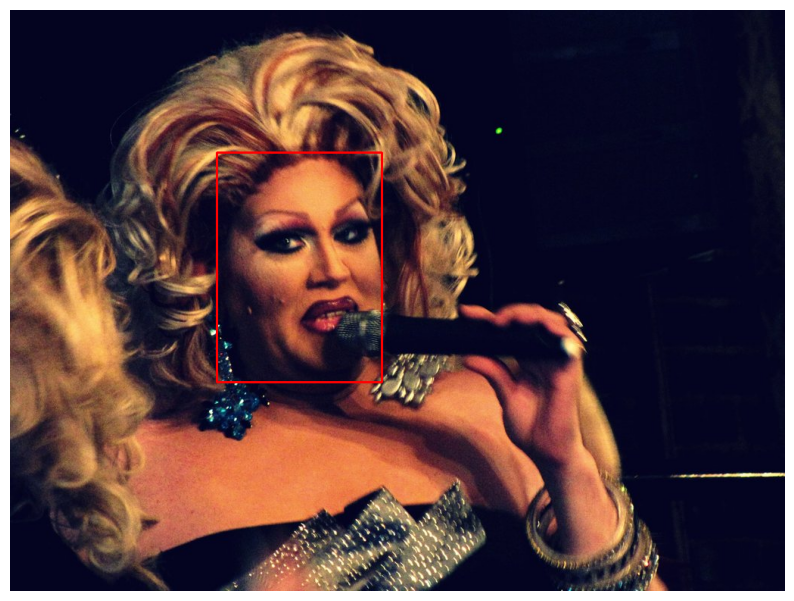

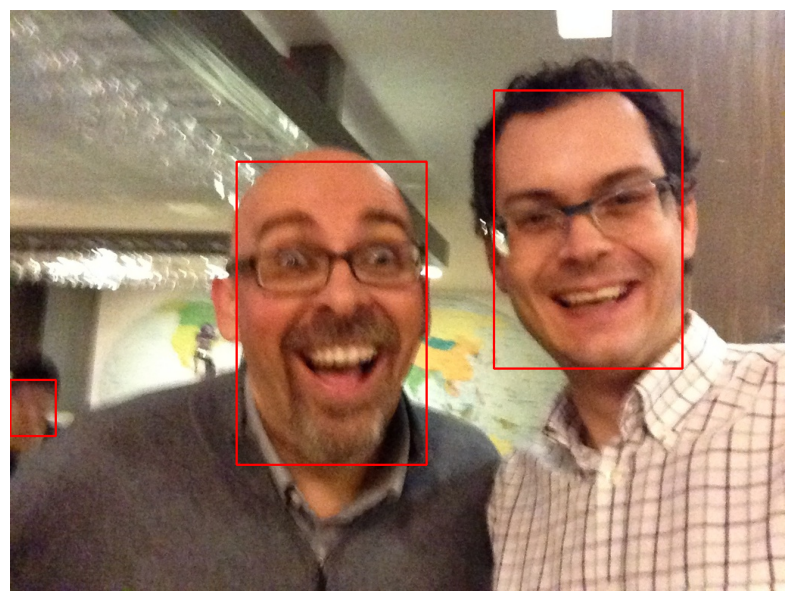

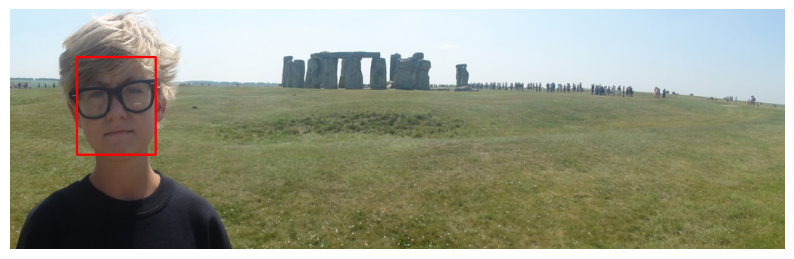

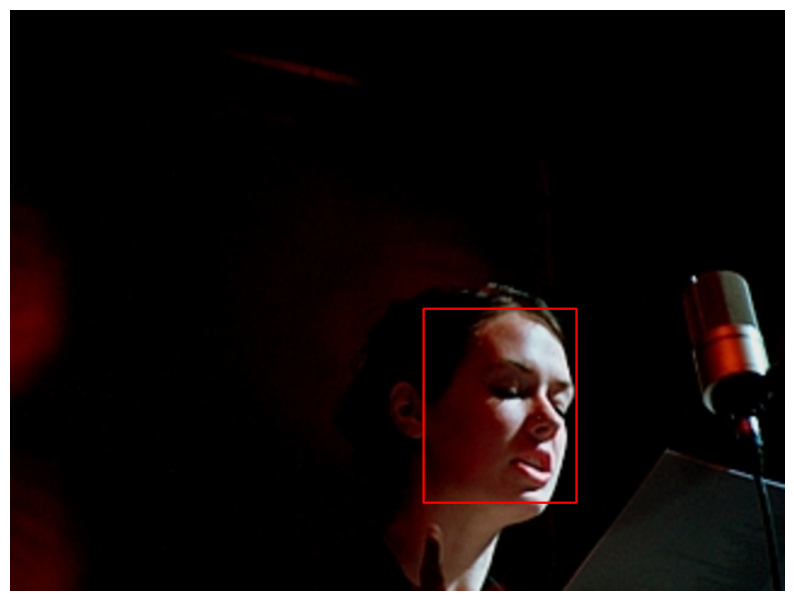

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

images_path = "dataset/images/train"  # images
labels_path = "dataset/labels/train"  # annations

# function to visualize the annations
def visualize_annotations(image_file, label_file, class_names=None):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # reading annotations
    with open(label_file, "r") as f:
        annotations = f.readlines()

    # Annotating an Image
    for ann in annotations:
        class_id, x_center, y_center, w, h = map(float, ann.split())
        x_center, y_center, w, h = (
            x_center * width,
            y_center * height,
            w * width,
            h * height,
        )
        x1, y1 = int(x_center - w / 2), int(y_center - h / 2)
        x2, y2 = int(x_center + w / 2), int(y_center + h / 2)

        # Displaying frames and marks
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_names:
            label = class_names[int(class_id)]
            cv2.putText(
                image,
                label,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2,
            )

    # Displaying images
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Visualizing the 5 images
image_files = sorted(os.listdir(images_path))[5:10]
for image_file in image_files:
    image_file_path = os.path.join(images_path, image_file)
    label_file_path = os.path.join(labels_path, image_file.replace(".jpg", ".txt"))
    if os.path.exists(label_file_path):
        visualize_annotations(image_file_path, label_file_path)
    else:
        print(f"Annotations for {image_file} is not found.")


In [4]:
import os
import cv2

input_labels_paths = {
    "train": "dataset/labels_raw/train",  
    "val": "dataset/labels_raw/val"      
}

output_labels_paths = {
    "train": "dataset/labels/train",  
    "val": "dataset/labels/val"       
}

images_paths = {
    "train": "dataset/images/train",
    "val": "dataset/images/val"    
}

# Function to convert annotations to YOLO format
def convert_to_yolo(input_labels_paths, output_labels_paths, images_paths):
    for dataset in ["train", "val"]:
        input_labels_path = input_labels_paths[dataset]
        output_labels_path = output_labels_paths[dataset]
        images_path = images_paths[dataset]
        
        # Create output folder
        os.makedirs(output_labels_path, exist_ok=True)

        for file_name in os.listdir(input_labels_path):
            input_file = os.path.join(input_labels_path, file_name)
            output_file = os.path.join(output_labels_path, file_name)

            # Path to the corresponding image
            image_file = os.path.join(images_path, file_name.replace(".txt", ".jpg"))
            if not os.path.exists(image_file):
                print(f"Image {image_file} not found. Skipping.")
                continue

            # Get image dimensions
            image = cv2.imread(image_file)
            img_height, img_width, _ = image.shape

            with open(input_file, "r") as infile, open(output_file, "w") as outfile:
                for line in infile:
                    data = line.split()
                    if data[0] == "Human":  # Check for the class
                        # Parse coordinates
                        x_min, y_min, x_max, y_max = map(float, data[2:])
                        x_center = ((x_min + x_max) / 2) / img_width
                        y_center = ((y_min + y_max) / 2) / img_height
                        width = (x_max - x_min) / img_width
                        height = (y_max - y_min) / img_height

                        # Write in YOLO format (class_id is always 0)
                        outfile.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Conversion for {dataset} completed!")

# Convert annotations for both folders
convert_to_yolo(input_labels_paths, output_labels_paths, images_paths)


Конвертация для train завершена!
Конвертация для val завершена!


In [5]:
import os


paths = {
    "train_images": "dataset/images/train",
    "val_images": "dataset/images/val",
    "train_labels": "dataset/labels/train",
    "val_labels": "dataset/labels/val",
}

# Counting number of files
def count_files(paths):
    counts = {}
    for key, path in paths.items():
        if os.path.exists(path):
            counts[key] = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        else:
            counts[key] = 0
    return counts

# Results
counts = count_files(paths)
for key, count in counts.items():
    print(f"{key}: {count} файлов")


train_images: 13386 файлов
val_images: 3347 файлов
train_labels: 13386 файлов
val_labels: 3347 файлов


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


**Training the yolo model that detects "Human Face"**

In [3]:
from ultralytics import YOLO


model = YOLO("yolov8n.pt")


model.train(
    data="data.yaml",
    epochs=20,
    batch=16,
    imgsz=640 
)



Ultralytics 8.3.63  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning C:\Users\Shind\study_projects\CV_tasks\identification_model\dataset\labels\train.cache... 13386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13386/13386 [00:00<?, ?it/s]
val: Scanning C:\Users\Shind\study_projects\CV_tasks\identification_model\dataset\labels\val.cache... 3347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3347/3347 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.2G      1.378      1.262      1.189         48        640: 100%|██████████| 837/837 [02:07<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:23<00:00,  4.55it/s]


                   all       3347      10299      0.852      0.679      0.773      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.97G      1.328     0.9189      1.158         57        640: 100%|██████████| 837/837 [02:02<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.33it/s]


                   all       3347      10299      0.872      0.705      0.794      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.68G      1.308     0.8728       1.15         49        640: 100%|██████████| 837/837 [01:51<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.56it/s]


                   all       3347      10299      0.883      0.706      0.794      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       3.5G      1.288     0.8296      1.136         57        640: 100%|██████████| 837/837 [01:50<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.51it/s]


                   all       3347      10299      0.874      0.743      0.816      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       3.5G      1.256     0.7922      1.123        134        640: 100%|██████████| 837/837 [01:49<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.60it/s]


                   all       3347      10299      0.878      0.749      0.828      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.25G      1.252     0.7718       1.12         37        640: 100%|██████████| 837/837 [01:50<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.57it/s]


                   all       3347      10299      0.871      0.758      0.834      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.16G      1.221     0.7353      1.104         52        640: 100%|██████████| 837/837 [01:49<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.56it/s]


                   all       3347      10299      0.885      0.772      0.845       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       3.6G      1.217      0.719      1.099         45        640: 100%|██████████| 837/837 [01:50<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.41it/s]


                   all       3347      10299      0.887      0.772      0.848      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.02G      1.203     0.7057      1.093         58        640: 100%|██████████| 837/837 [01:51<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:21<00:00,  4.99it/s]

                   all       3347      10299       0.89      0.775      0.852      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.41G      1.193     0.6844      1.086         52        640: 100%|██████████| 837/837 [01:51<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:20<00:00,  5.15it/s]


                   all       3347      10299      0.896      0.786      0.861      0.561
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.58G      1.189     0.6562       1.09         21        640: 100%|██████████| 837/837 [02:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.57it/s]


                   all       3347      10299      0.889      0.776      0.854      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.66G      1.178     0.6503      1.081         23        640: 100%|██████████| 837/837 [01:53<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:20<00:00,  5.15it/s]

                   all       3347      10299      0.896      0.783      0.861      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.47G      1.165     0.6244      1.076         19        640: 100%|██████████| 837/837 [02:16<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.46it/s]

                   all       3347      10299      0.893      0.785      0.864       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.51G      1.157     0.6109      1.073         33        640: 100%|██████████| 837/837 [01:53<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.56it/s]


                   all       3347      10299      0.889      0.793      0.867      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.63G      1.149     0.6015       1.07         26        640: 100%|██████████| 837/837 [01:48<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.52it/s]

                   all       3347      10299      0.885      0.795      0.867      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.24G      1.138     0.5866      1.062         20        640: 100%|██████████| 837/837 [01:49<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.35it/s]

                   all       3347      10299      0.901      0.794      0.874      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.57G      1.128     0.5729      1.055         21        640: 100%|██████████| 837/837 [02:17<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:18<00:00,  5.56it/s]

                   all       3347      10299      0.895      0.799      0.874      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.39G       1.12     0.5619       1.05         28        640: 100%|██████████| 837/837 [01:47<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.42it/s]

                   all       3347      10299      0.893      0.805      0.878      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.34G      1.112     0.5506      1.045         34        640: 100%|██████████| 837/837 [01:48<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.49it/s]

                   all       3347      10299      0.896      0.804      0.879      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.54G      1.105     0.5367       1.04         34        640: 100%|██████████| 837/837 [01:48<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.47it/s]

                   all       3347      10299      0.898      0.807      0.881      0.587



20 epochs completed in 0.770 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.63  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:22<00:00,  4.68it/s]


                   all       3347      10299      0.898      0.806      0.881      0.587
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002348BBCB5E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

**TESTING YOLO MODEL**

In [2]:
import cv2
from ultralytics import YOLO
import time

# 1. Initialize YOLO model
def initialize_yolo(model_path):
    print("[INFO] Initializing YOLO model...")
    detector = YOLO(model_path)
    print("[INFO] YOLO model loaded successfully!")
    return detector

# 2. Process video stream
def process_video_stream(detector):
    print("[INFO] Starting video stream...")
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("[ERROR] Failed to open the camera.")
        return

    prev_time = 0  # For calculating FPS

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("[ERROR] Failed to capture a frame from the video stream.")
            break

        # Start time for FPS calculation
        current_time = time.time()

        # Perform object detection
        results = detector(frame)

        # Iterate over detected objects
        for result in results[0].boxes:
            x1, y1, x2, y2 = map(int, result.xyxy[0])  # Bounding box coordinates
            conf = result.conf[0]  # Confidence score
            cls = result.cls[0]  # Class ID
            class_name = detector.names[int(cls)]  # Get class name ("human face")

            # Draw bounding box and detection information on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{class_name} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Calculate FPS
        fps = 1 / (current_time - prev_time) if prev_time > 0 else 0
        prev_time = current_time

        # Display FPS on the frame
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # Show the frame with detections
        cv2.imshow("YOLO Object Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("[INFO] Video stream ended.")
            break

    cap.release()
    cv2.destroyAllWindows()

# Main program block
if __name__ == "__main__":
    # Path to the YOLO model
    model_path = "runs/detect/train4/weights/best.pt"

    # Step 1: Initialize the YOLO model
    detector = initialize_yolo(model_path)

    # Step 2: Start the video stream
    process_video_stream(detector)


[INFO] Initializing YOLO model...
[INFO] YOLO model loaded successfully!
[INFO] Starting video stream...

0: 480x640 1 Human face, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 8.8ms
Speed: 1.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 9.8ms
Speed: 1.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 4

**IDENTIFICATION**

In [ ]:
import cv2
import time
from ultralytics import YOLO
import os
from deepface import DeepFace
import numpy as np
from datetime import datetime

# 1. Initialize the YOLOv8 model
detector = YOLO("runs/detect/train4/weights/best.pt").to("cuda")
print("Model YOLOv8 loaded.")

# 2. Function to create an embedding database
def create_embedding_database(dataset_path, model_name="VGG-Face"):
    embeddings_db = []
    print(f"Started loading to DB from folder: {dataset_path}")
    for person_dir in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_dir)
        if os.path.isdir(person_path):
            person_name = person_dir.split("_")
            if len(person_name) < 3:
                print(f"Skipping folder: {person_dir} (Uncorrect format name for folder)")
                continue
            surname, firstname, person_id = person_name
            image_path = os.path.join(person_path, f"{person_dir}.jpg")
            if os.path.exists(image_path):
                try:
                    embedding = DeepFace.represent(img_path=image_path, model_name=model_name, enforce_detection=False)
                    embeddings_db.append({
                        "embedding": embedding[0]["embedding"],
                        "surname": surname,
                        "firstname": firstname,
                        "id": person_id
                    })
                    print(f"Added: {surname} {firstname} {person_id}")
                except Exception as e:
                    print(f"Error processing of {image_path}: {e}")
            else:
                print(f"File not found: {image_path}")
    print("Database loaded!")
    return embeddings_db

# 3. Function to preprocess a face with padding
def preprocess_face_with_padding(face_img, target_size=(224, 224)):
    h, w = face_img.shape[:2]
    scale = target_size[0] / max(h, w)
    resized_face = cv2.resize(face_img, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    top_pad = (target_size[1] - resized_face.shape[0]) // 2
    bottom_pad = target_size[1] - resized_face.shape[0] - top_pad
    left_pad = (target_size[0] - resized_face.shape[1]) // 2
    right_pad = target_size[0] - resized_face.shape[1] - left_pad
    face_with_padding = cv2.copyMakeBorder(
        resized_face, top_pad, bottom_pad, left_pad, right_pad,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )
    return face_with_padding

# 4. Function to identify faces
def identify_face(face_img, embeddings_db, model_name="VGG-Face", threshold=1):
    try:
        face_representation = DeepFace.represent(
            img_path=face_img,
            model_name=model_name,
            enforce_detection=False
        )
        face_embedding = np.array(face_representation[0]["embedding"])

        for entry in embeddings_db:
            db_embedding = np.array(entry["embedding"])
            distance = np.linalg.norm(db_embedding - face_embedding)
            if distance < threshold:
                return f"{entry['surname']} {entry['firstname']} {entry['id']}"
    except Exception as e:
        print(f"Identification error: {e}")

    return "Unknown"

# 5. Function to log entry to a file
def log_entry(student_name, file_path="attendance_log.csv"):
    with open(file_path, "a") as file:
        now = datetime.now()
        file.write(f"{now.strftime('%Y-%m-%d')}, {now.strftime('%H:%M:%S')}, {student_name}\n")
        print(f"Logged: {student_name} at {now.strftime('%Y-%m-%d %H:%M:%S')}")

# 6. Start the camera
cap = cv2.VideoCapture(0)
embeddings_db = create_embedding_database("dataset")

print("Start video...")
prev_time = 0
last_detection_time = 0
detection_interval = 5
last_result = None  # Store the last detection result

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()
    fps = 1 / (current_time - prev_time) if prev_time > 0 else 0
    prev_time = current_time

    # Perform object detection every 5 seconds
    if current_time - last_detection_time >= detection_interval:
        results = detector(frame)
        last_detection_time = current_time  # Update the last detection time

        for result in results[0].boxes:
            x1, y1, x2, y2 = map(int, result.xyxy[0])
            face = frame[y1:y2, x1:x2]
            if face.size == 0:
                continue
            face = preprocess_face_with_padding(face)
            name = identify_face(face, embeddings_db)
            last_result = name
            log_entry(name)  # Log the student's entry
            break

    # Display last detection result on the frame
    if last_result:
        cv2.putText(frame, f"Detected: {last_result}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Display FPS on the frame
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.imshow("Face Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model YOLOv8 loaded.
Started loading to DB from folder: dataset
Skipping folder: images (Uncorrect format name for folder)
Added: Kaz Aibolat 003
Skipping folder: labels (Uncorrect format name for folder)
Added: Sembay Kuanysh 001
Database loaded!
Start video...

0: 480x640 (no detections), 70.4ms
Speed: 9.0ms preprocess, 70.4ms inference, 115.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 31.5ms
Speed: 8.1ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 19.0ms
Speed: 4.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Human face, 17.6ms
Speed: 3.0ms preprocess, 17.6ms inference, 317.7ms postprocess per image at shape (1, 3, 480, 640)
Logged: Unknown at 2025-02-02 04:35:09

0: 480x640 1 Human face, 17.5ms